# Loading Data


In [1]:
# Load the Data
import pandas as pd

malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})


# clean_data = clean_data.drop(['ID','Subjectivity', 'Sentiment Polarity', 'Sarcasm', 'Irony', 'Negation'], axis=1)
clean_data = clean_data.drop(['ID'], axis=1)

clean_data.head()
clean_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
5068,"Wow growing together, so I will get a 17 black...",1,positive,disgust,0,1,0
5069,Equal pay for equal work to be introduced in t...,1,positive,anticipation,0,0,1
5070,No cash when worth more then 10000?. Use offsh...,1,negative,anticipation,0,1,0
5071,"Budget 2020 reactions: Some say it’s good, oth...",1,negative,anger,0,0,0
5072,"Budget 2020 reactions: Some say it’s good, oth...",1,neutral,sadness,0,0,0


# General Preprocessing

In [2]:
# Handle text processing and tokenisation:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

processed_data.head()

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,masks
0,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


# Lexicon Based Features 

In [3]:
def normalize(column):
    min_value = column.min()
    max_value = column.max()
    return (column - min_value) / (max_value - min_value) if max_value != min_value else column

In [4]:
# Punctuation Counts
import re
import pandas as pd

def count_punctuation(text, tokens):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    
    token_count = len(tokens)
    if token_count == 0:
        token_count = 1
    
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count
    })

processed_data = processed_data.join(
    processed_data.apply(lambda row: count_punctuation(row['Raw_Text'], row['tokens']), axis=1)
)

# Normalize the count columns and create the score columns
processed_data['exclamation_score'] = normalize(processed_data['exclamation_count'])
processed_data['question_score'] = normalize(processed_data['question_count'])
processed_data['ellipsis_score'] = normalize(processed_data['ellipsis_count'])
processed_data['comma_score'] = normalize(processed_data['comma_count'])
processed_data['period_score'] = normalize(processed_data['period_count'])

# View the first few rows of the processed data
processed_data.head()

,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,...,exclamation_count,question_count,ellipsis_count,comma_count,period_count,exclamation_score,question_score,ellipsis_score,comma_score,period_score
0,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...",...,0,0,0,0,5,0.000000,0.0000,0.000000,0.00,0.277778
1,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...",...,2,1,0,1,0,0.083333,0.0625,0.000000,0.05,0.000000
2,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...",...,0,0,0,0,0,0.000000,0.0000,0.000000,0.00,0.000000
3,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...",...,0,1,1,2,2,0.000000,0.0625,0.041667,0.10,0.111111
4,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...",...,0,1,0,1,0,0.000000,0.0625,0.000000,0.05,0.000000


In [5]:
# Polarity 
nrc_lexicon_path = '../Lexicons/NRC/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])

# Get pos and neg words
positive_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'positive') & (nrc_lexicon['association'] == 1)]['word'].tolist()
negative_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'negative') & (nrc_lexicon['association'] == 1)]['word'].tolist()

def count_polarity_words(tokens, positive_words, negative_words):
    pos_count = 0
    neg_count = 0
    for token in tokens:
        if token in positive_words:
            pos_count +=1 
        if token in negative_words:
            neg_count +=1
            
    return pos_count, neg_count

processed_data[['pos_count', 'neg_count']] = processed_data['tokens'].apply(
    lambda x: pd.Series(count_polarity_words(x, positive_words, negative_words))
    )

processed_data['neg_score'] = normalize(processed_data['neg_count'])
processed_data['pos_score'] = normalize(processed_data['pos_count'])

print(processed_data)

                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [6]:
from afinn import Afinn

afinn = Afinn()
processed_data['afinn_count'] = processed_data['Raw_Text'].apply(lambda x: afinn.score(x))

processed_data['afinn_score'] = normalize(processed_data['afinn_count'])

print(processed_data)

                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [7]:
#objectivity scores 
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

def get_sentiwordnet_scores(tokens):
    score = 0
    for token in tokens:
        synsets = wn.synsets(token)
        if not synsets:
            continue  # No synset found for the word

        synset = synsets[0]  # Take the first synset
        swn_synset = swn.senti_synset(synset.name())
        score += swn_synset.obj_score()
    if len(tokens) == 0: # if there are no tokens, then assume objective
        return 1.0
    return score / len(tokens)

processed_data['obj_score'] = processed_data['tokens'].apply(lambda tokens: get_sentiwordnet_scores(tokens)) 

print(processed_data)

[nltk_data] Error loading sentiwordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def extract_vader_features(text):
    sentiment = sia.polarity_scores(text)
    return pd.Series({
        'vader_neg': sentiment['neg'],
        'vader_neu': sentiment['neu'],
        'vader_pos': sentiment['pos'],
        'vader_compound': sentiment['compound']
    })

vader_features = processed_data['Raw_Text'].apply(extract_vader_features)

processed_data = pd.concat([processed_data, vader_features], axis=1)

print(processed_data.head())

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

  Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0           positive         trust        0      0         1   
1           negative       disgust        0      0         1   
2            neutral  anticipation        0      0         0   
3           negative       sadness        0      0         0   
4           negative         anger        0      0         1   

                                            Raw_Text  \
0  Great BUDGET . Even cigarettes were not touche...   
1  I haven't exactly scanned the budget throughou...   
2  There’s already smoking

# Computational Feature engineering 

In [9]:
# Polarity. 
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Load sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def get_sentiment(tokens):
    total_score = 0
    result = sentiment_analyzer(tokens)
    if len(result) == 0:
        return 0.0
    for r in result:
        total_score += r['score']
    return total_score / len(result)

processed_data['polarity_score'] = processed_data['tokens'].apply(get_sentiment)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [10]:
# Subjectivity
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertModel, AutoTokenizer
import torch
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
bert_model = BertModel.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")

# Tokenize and convert to BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

X = get_bert_embeddings(processed_data['Text'])
y = processed_data['Subjectivity']

# Train SVM classifier
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
clf.fit(X, y)

# Get the decision function values or probabilities
subjectivity_probabilities = clf.predict_proba(X)

# Assuming binary classification, we take the probability of the positive class (index 1)
processed_data['subjectivity_score'] = subjectivity_probabilities[:, 1]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Sarcasm detection using BERT and LSTM
import torch
import torch.nn as nn

class SarcasmLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, num_layers):
        super(SarcasmLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        logits = self.fc(lstm_output[:, -1, :])
        return self.sigmoid(logits)

tokenizer = AutoTokenizer.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
bert_model = BertModel.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")

# Initialize the LSTM model
sarcasm_model = SarcasmLSTM(bert_model, hidden_dim=256, output_dim=1, num_layers=2)

# Tokenize and predict sarcasm for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    sarcasm_prob = sarcasm_model(inputs).numpy()

processed_data['sarcasm_score'] = sarcasm_prob.flatten()  # Keep the raw probability

In [12]:
# Irony
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd

# Load the fine-tuned RoBERTa model and tokenizer for irony detection
tokenizer = AutoTokenizer.from_pretrained("vikram71198/roberta-base-finetuned-irony")
roberta_model = AutoModelForSequenceClassification.from_pretrained("vikram71198/roberta-base-finetuned-irony")

# Function to get predictions directly from the RoBERTa model
def detect_irony(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    
    # Convert logits to probabilities
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # The model returns a probability for each class (ironic or not ironic)
    # Assuming binary classification (ironic vs. not ironic), we take the probability for the 'ironic' class
    irony_scores = probabilities[:, 1].numpy()  # Index 1 is usually for the positive class
    
    return irony_scores

# Assume processed_data is your DataFrame containing a 'Text' column
# Get irony_scores for each text in the DataFrame
processed_data['irony_score'] = detect_irony(processed_data['Text'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
processed_data = processed_data.dropna()

# Feature examination

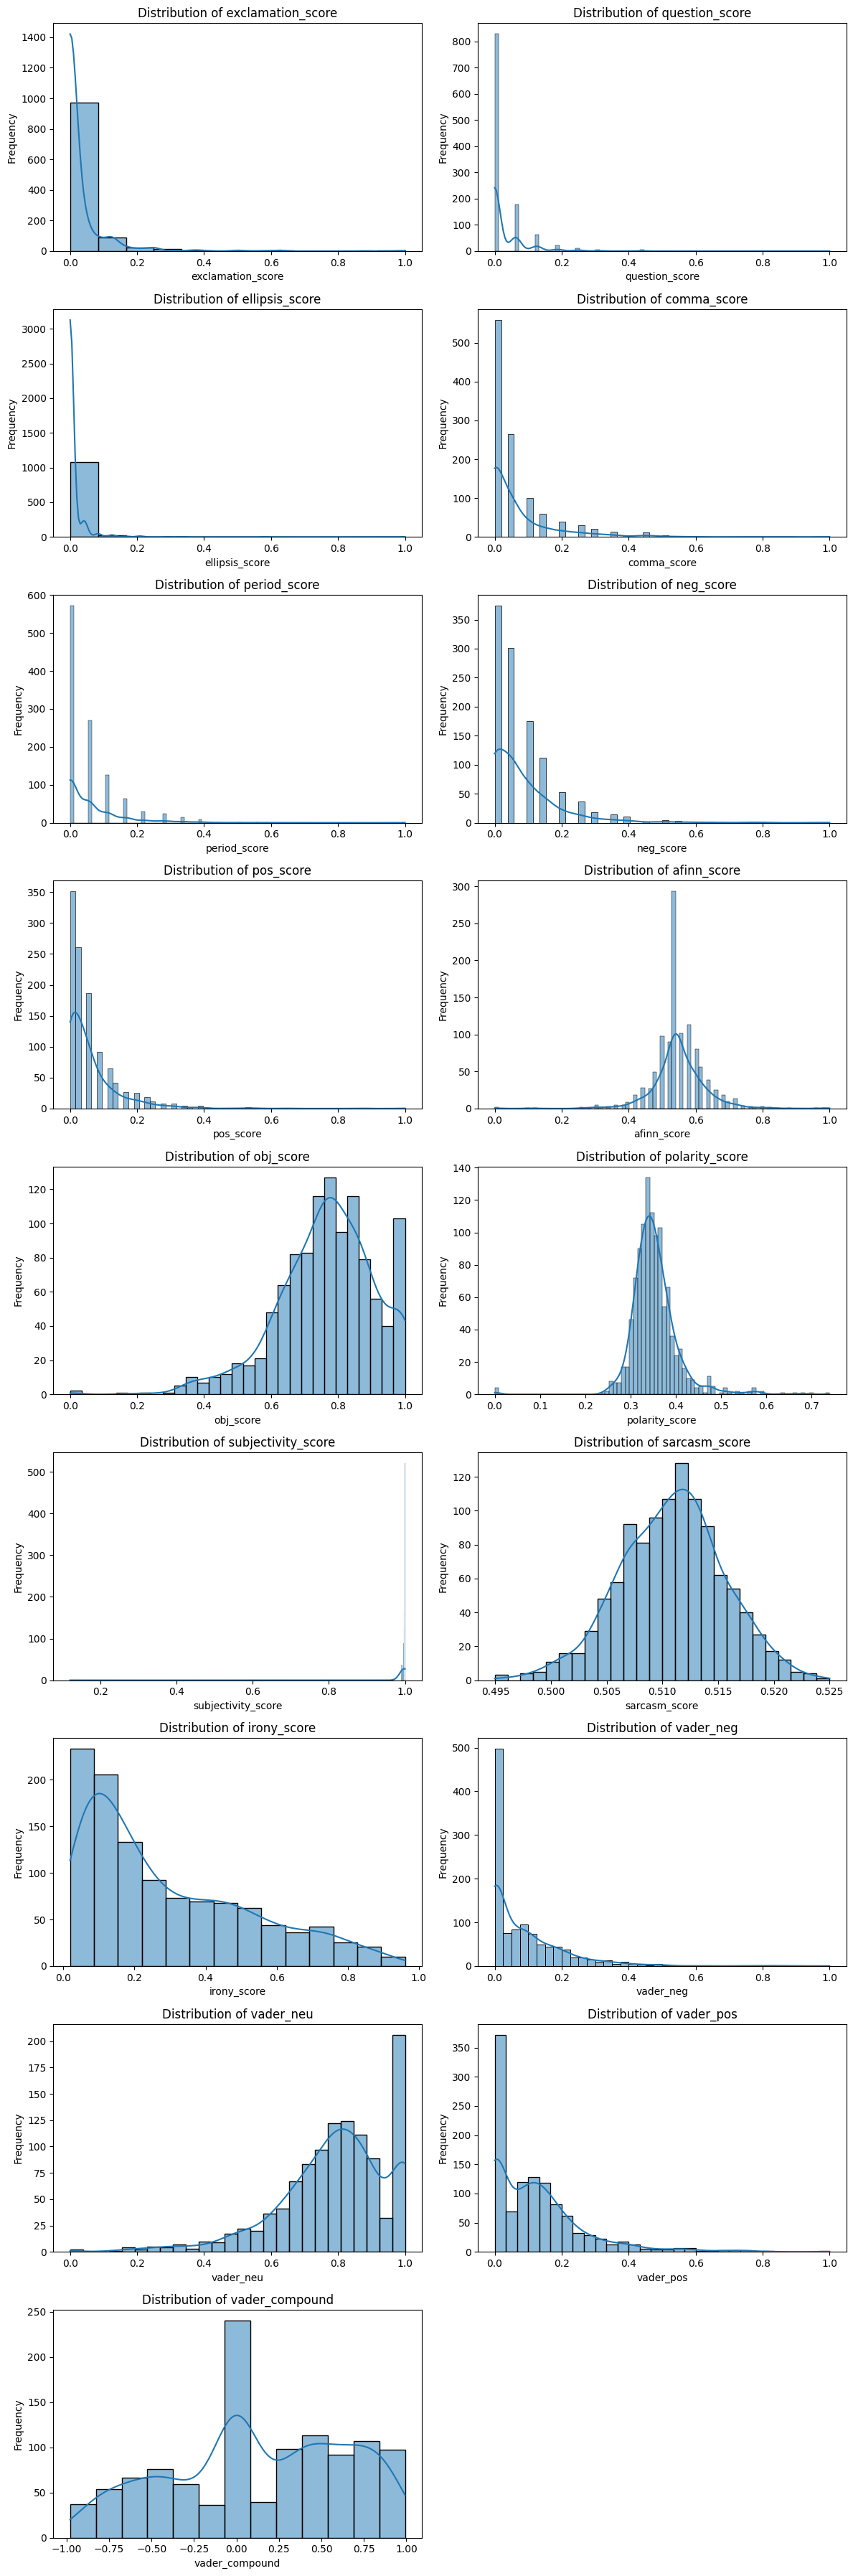

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# List of features to plot (using suffixes to include TEC, TEI, MEI, GEC, GEI)
feature_columns = [col for col in processed_data.columns if any(suffix in col for suffix in ['_score'])]
feature_columns = feature_columns + ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

# Determine number of rows needed (2 columns per row)
n_features = len(feature_columns)
n_rows = math.ceil(n_features / 2)

# Create subplots with 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows * 4))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each feature's histogram in the grid
for i, feature in enumerate(feature_columns):
    sns.histplot(processed_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

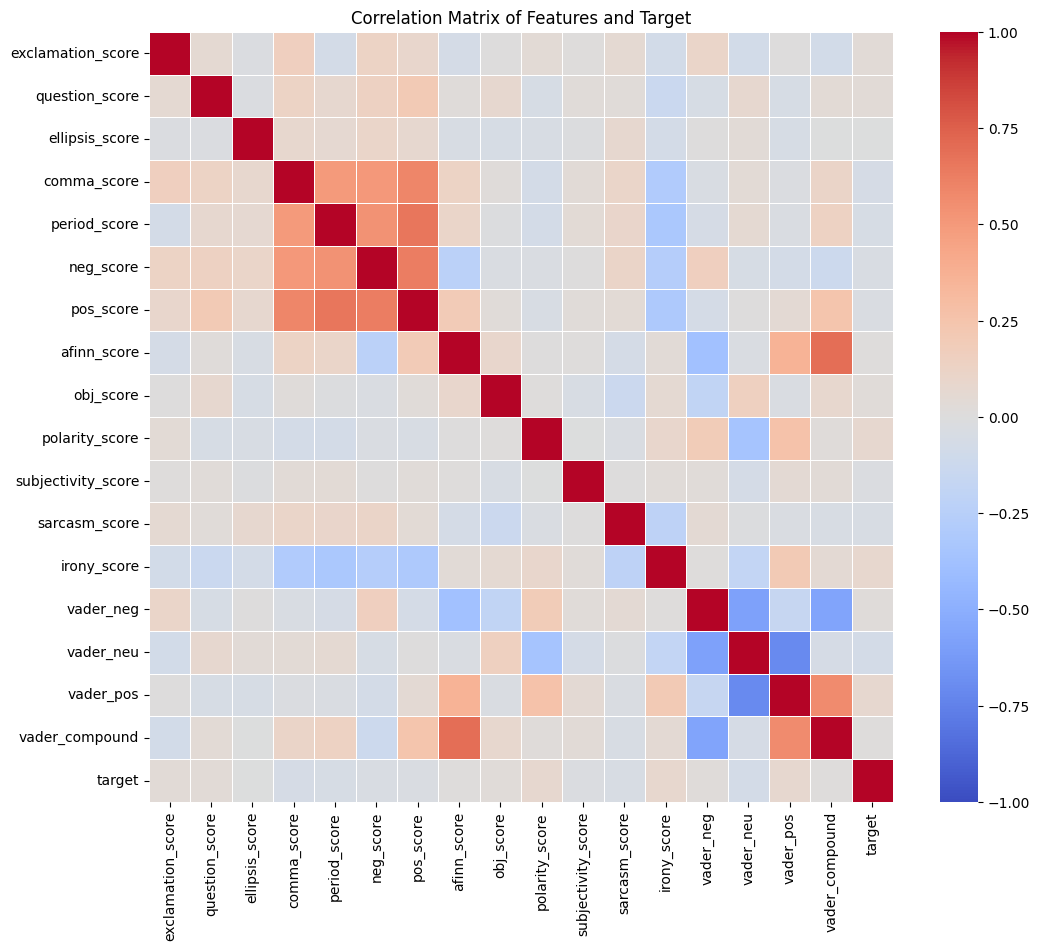

In [15]:
mapping_dict = {value: index for index, value in enumerate(processed_data['Emotion'].unique())}
processed_data['target'] = processed_data['Emotion'].map(mapping_dict)

correlation_data = processed_data[feature_columns + ['target']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features and Target')
plt.show()

# Feature Selection

In [16]:
features = []

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def featureSelection(n_features_to_select):
    # Assuming 'target' is your dependent variable and the feature columns are independent variables
    X = processed_data[feature_columns]
    y = processed_data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = LogisticRegression(max_iter=2000, random_state=42)

    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features: {accuracy}")
    features.append({'model':'Logistic_Regression', 'features':len(selected_features), 'accuracy':accuracy})

In [18]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['exclamation_score', 'vader_pos']
Model accuracy with selected features: 0.23318385650224216
Selected Features:  ['exclamation_score', 'vader_neg', 'vader_pos']
Model accuracy with selected features: 0.2600896860986547
Selected Features:  ['exclamation_score', 'neg_score', 'vader_neg', 'vader_pos']
Model accuracy with selected features: 0.242152466367713
Selected Features:  ['exclamation_score', 'question_score', 'neg_score', 'vader_neg', 'vader_pos']
Model accuracy with selected features: 0.27802690582959644
Selected Features:  ['exclamation_score', 'question_score', 'neg_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.2645739910313901
Selected Features:  ['exclamation_score', 'question_score', 'neg_score', 'afinn_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.2600896860986547
Selected Features:  ['exclamation_score', 'question_score', 'neg_score', 'afinn_score', 'obj_score', 'vader_n

In [19]:
from sklearn.svm import SVC

def featureSelection(n_features_to_select):
    X = processed_data[feature_columns]
    y = processed_data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    svm_model = SVC(kernel='linear', random_state=42)

    rfe = RFE(estimator=svm_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    svm_model.fit(X_train_rfe, y_train)

    y_pred = svm_model.predict(X_test_rfe)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features: {accuracy}")
    features.append({'model':'Linear_SVM', 'features':len(selected_features), 'accuracy':accuracy})

In [20]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['vader_neg', 'vader_neu']
Model accuracy with selected features: 0.242152466367713
Selected Features:  ['vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.25112107623318386
Selected Features:  ['exclamation_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.2600896860986547
Selected Features:  ['exclamation_score', 'neg_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.25112107623318386
Selected Features:  ['exclamation_score', 'question_score', 'neg_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.25112107623318386
Selected Features:  ['exclamation_score', 'question_score', 'neg_score', 'afinn_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.25112107623318386
Selected Features:  ['exclamation_score', 'question_score', 'neg_score', 'afinn_score', 'obj_score', 'vader_neg', 'vader_neu', '

In [21]:
from sklearn.ensemble import RandomForestClassifier

def featureSelection(n_features_to_select):
    X = processed_data[feature_columns]
    y = processed_data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    rf_model = RandomForestClassifier(random_state=42)

    rfe = RFE(estimator=rf_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    rf_model.fit(X_train_rfe, y_train)

    y_pred = rf_model.predict(X_test_rfe)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features (RandomForest): {accuracy}")
    features.append({'model':'Random_Forest_Classifier', 'features':len(selected_features), 'accuracy':accuracy})

In [22]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['polarity_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.13452914798206278
Selected Features:  ['polarity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.16143497757847533
Selected Features:  ['polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.21076233183856502
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.23318385650224216
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (RandomForest): 0.23318385650224216
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu', 'vader_compound']
Model accuracy with selected features (RandomFores

In [23]:
from sklearn.tree import DecisionTreeClassifier

def featureSelection(n_features_to_select):
    X = processed_data[feature_columns]
    y = processed_data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    dt_model = DecisionTreeClassifier(random_state=42)

    rfe = RFE(estimator=dt_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    dt_model.fit(X_train_rfe, y_train)

    y_pred = dt_model.predict(X_test_rfe)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features (DecisionTree): {accuracy}")
    features.append({'model':'Decision_Tree_Classifier', 'features':len(selected_features), 'accuracy':accuracy})

In [24]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['polarity_score', 'irony_score']
Model accuracy with selected features (DecisionTree): 0.15246636771300448
Selected Features:  ['polarity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (DecisionTree): 0.15246636771300448
Selected Features:  ['polarity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (DecisionTree): 0.17937219730941703
Selected Features:  ['polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (DecisionTree): 0.16143497757847533
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (DecisionTree): 0.17488789237668162
Selected Features:  ['afinn_score', 'obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (DecisionTree): 0.183856

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

def featureSelection(n_features_to_select):
    X = processed_data[feature_columns]
    y = processed_data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    gb_model = GradientBoostingClassifier(random_state=42)

    rfe = RFE(estimator=gb_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    gb_model.fit(X_train_rfe, y_train)

    y_pred = gb_model.predict(X_test_rfe)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features (GradientBoosting): {accuracy}")
    features.append({'model':'Gradient_Boosting_classifier', 'features':len(selected_features), 'accuracy':accuracy})

In [26]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['polarity_score', 'irony_score']
Model accuracy with selected features (GradientBoosting): 0.17040358744394618
Selected Features:  ['polarity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (GradientBoosting): 0.19282511210762332
Selected Features:  ['polarity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.2645739910313901
Selected Features:  ['obj_score', 'polarity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.25112107623318386
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.25112107623318386
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu', 'vader_compound']
Model accuracy with selected featu

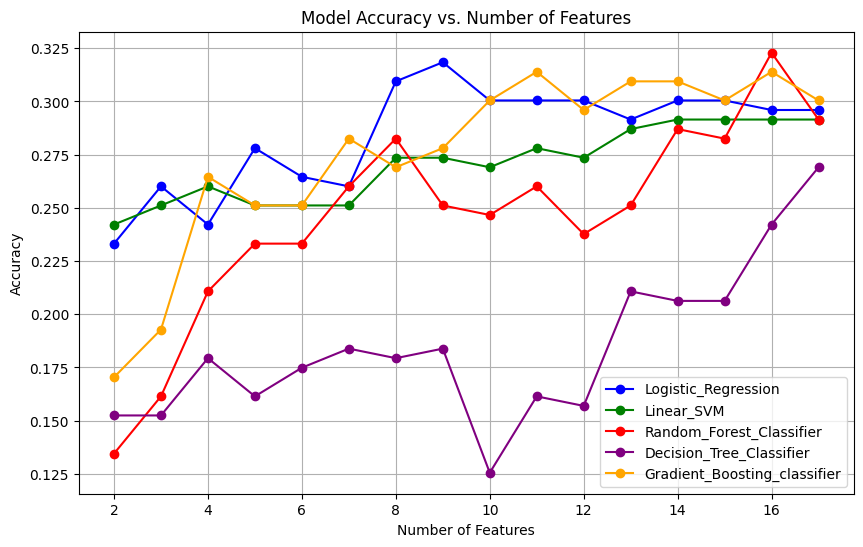

In [27]:
features_df = pd.DataFrame(features)

plt.figure(figsize=(10, 6))

# Assign a color for each model
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot data with different colors for each model
for idx, model_name in enumerate(features_df['model'].unique()):
    model_data = features_df[features_df['model'] == model_name]
    plt.plot(model_data['features'], model_data['accuracy'], label=model_name, color=colors[idx], marker='o')

# Add labels and title
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
to_keep = ['exclamation_score', 'question_score', 'neg_score', 'afinn_score', 'obj_score', 'vader_neg', 'vader_neu', 'vader_pos']

fuzzy_data = processed_data[to_keep]
score_description = fuzzy_data.describe()
score_description

,exclamation_score,question_score,neg_score,afinn_score,obj_score,vader_neg,vader_neu,vader_pos
count,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,0.027154,0.027996,0.086266,0.549605,0.765192,0.085763,0.791485,0.122758
std,0.083845,0.067064,0.114277,0.081222,0.146500,0.119175,0.166462,0.137257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.520000,0.680783,0.000000,0.706000,0.000000
50%,0.000000,0.000000,0.050000,0.540000,0.776179,0.045000,0.808500,0.099000
75%,0.000000,0.062500,0.100000,0.580000,0.861945,0.130750,0.905750,0.177000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


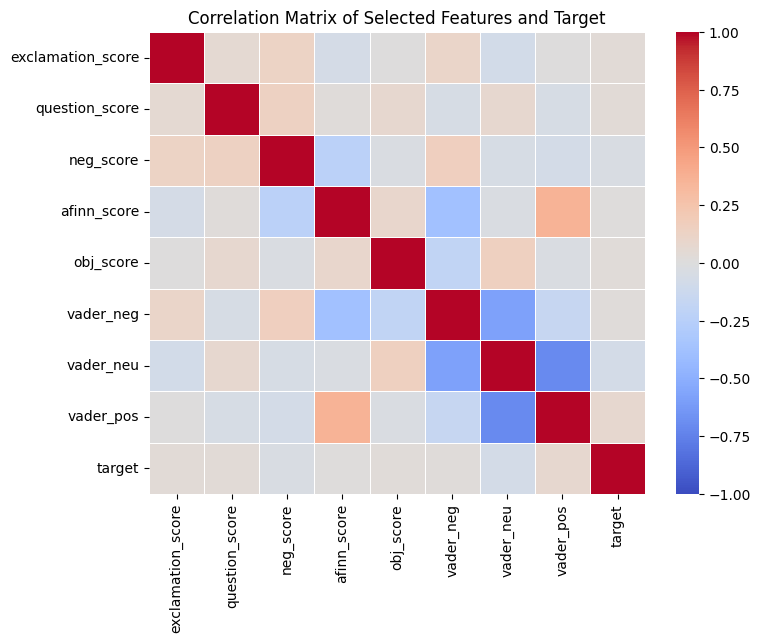

In [29]:
correlation_data = processed_data[to_keep + ['target']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features and Target')
plt.show()

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

import sys
sys.path.insert(0, 'code/')
from anfis import ANFIS, predict
import membershipfunction

In [31]:
def doAnfis(X_train, X_test, Y_train, Y_test, epochs, mf):
    # Initialize Membership functions and ANFIS
    mfc = membershipfunction.MemFuncs(mf)
    anf = ANFIS(X_train, Y_train, mfc)
    
    # Train the ANFIS model
    anf.trainHybridJangOffLine(epochs=epochs)
    
    # Make predictions on the test set
    predictions = predict(anf, X_test)
    
    # Post-process predictions to match Y_train/Y_test dimensions
    # Rounding predictions to the nearest integer as the output should be categorical
    predictions_rounded = np.rint(predictions).astype(int).flatten()
    
    # Ensure predictions are within the valid label range
    min_label = Y_train.min()
    max_label = Y_train.max()
    predictions_clipped = np.clip(predictions_rounded, min_label, max_label)
    
    # Accuracy calculation
    accuracy = accuracy_score(Y_test, predictions_clipped)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    ## TODO: add lines to the error plots ####
    anf.plotErrors()
    anf.plotResults()
    
    return anf, predictions_clipped

In [32]:
# mf = [
#     # exclamation_score
#     [['sigmf', {'b': 0.0, 'c': -10}],   # Low exclamation
#      ['sigmf', {'b': 0.111, 'c': 10}]],    # High exclamation (sensitive to spikes)

#     # question_score
#     [['sigmf', {'b': 0.0, 'c': -10}],   # Low question
#      ['sigmf', {'b': 0.095, 'c': 10}]],    # High question (sensitive to spikes)

#     # neg_score
#     [['gaussmf', {'mean': 0.03, 'sigma': 0.02}],  # Very low negativity
#      ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]],   # Slight to moderate negativity

#     # afinn_score
#     [['gbellmf', {'a': 0.162, 'b': 2, 'c': 0.468}],  # Negative to low afinn  mean - 0.549605
#      ['gbellmf', {'a': 0.162, 'b': 2, 'c': 0.631}]], # Moderate to high afinn

#     # obj_score
#     [['gaussmf', {'mean': 0.7, 'sigma': 0.05}],  # Moderate objectivity
#      ['gaussmf', {'mean': 0.85, 'sigma': 0.05}]], # High objectivity

#     # vader_neg
#     [['gaussmf', {'mean': 0.03, 'sigma': 0.02}], # Very low negativity
#      ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]], # Low to moderate negativity

#     # vader_neu
#     [['gaussmf', {'mean': 0.7, 'sigma': 0.05}],  # Moderate neutrality
#      ['gaussmf', {'mean': 0.9, 'sigma': 0.05}]], # High neutrality

#     # vader_pos
#     [['sigmf', {'b': 0.0, 'c': -10}],   # Low positivity
#      ['sigmf', {'b': 0.260, 'c': 10}]]    # High positivity
# ]

mf = [
    # exclamation_score
    [['gaussmf', {'mean': 0.0, 'sigma': 0.02}],  # Very low exclamation
     ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]],  # Moderate to high exclamation  #sigma 0.5

    # question_score
    [['gaussmf', {'mean': 0.0, 'sigma': 0.02}],  # Very low question
     ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]],  # Moderate to high question  #sigma 0.5

    # neg_score
    [['gaussmf', {'mean': 0.03, 'sigma': 0.02}],  # Very low negativity
     ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]],  # Moderate negativity

    # afinn_score
    [['gaussmf', {'mean': 0.5, 'sigma': 0.05}],   # Low to moderate afinn
     ['gaussmf', {'mean': 0.7, 'sigma': 0.05}]],  # High afinn score  #mean 0.7 

    # obj_score
    [['gaussmf', {'mean': 0.7, 'sigma': 0.05}],  # Moderate objectivity
     ['gaussmf', {'mean': 0.85, 'sigma': 0.05}]], # High objectivity

    # vader_neg
    [['gaussmf', {'mean': 0.03, 'sigma': 0.02}], # Very low negativity
     ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]], # Low to moderate negativity

    # vader_neu
    [['gaussmf', {'mean': 0.7, 'sigma': 0.05}],  # Moderate neutrality
     ['gaussmf', {'mean': 0.9, 'sigma': 0.05}]], # High neutrality

    # vader_pos
    [['gaussmf', {'mean': 0.05, 'sigma': 0.03}],  # Low positivity
     ['gaussmf', {'mean': 0.15, 'sigma': 0.05}]]  # Moderate positivity
]


# Subset the dataframe for input features
fuzzy_data = processed_data[to_keep]

# Mapping the target variable (Emotion) to numeric values
mapping_dict = {value: index for index, value in enumerate(processed_data['Emotion'].unique())}
processed_data['Emotion_mapped'] = processed_data['Emotion'].map(mapping_dict)

# Input (X) and Target (Y) variables
X = fuzzy_data.values
Y = processed_data['Emotion_mapped'].values

# Split the data into training and testing sets using train_test_split with stratification
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

Processing:   0%|          | 0/25 [00:00<?, ?it/s]

current error: 1789.1771209884487


Processing:   4%|▍         | 1/25 [10:43<4:17:19, 643.31s/it]

current error: 1746.3797175687519


Processing:   8%|▊         | 2/25 [21:40<4:09:48, 651.66s/it]

current error: 1683.6992550776808


Processing:  12%|█▏        | 3/25 [32:45<4:01:07, 657.61s/it]

current error: 1721.4188573387928


Processing:  16%|█▌        | 4/25 [43:49<3:50:59, 659.99s/it]

current error: 1767.4499395182925


Processing:  20%|██        | 5/25 [55:04<3:41:52, 665.64s/it]

current error: 1796.683187879862


Processing:  24%|██▍       | 6/25 [1:06:19<3:31:44, 668.63s/it]

current error: 1835.8241603249478


Processing:  28%|██▊       | 7/25 [1:17:20<3:19:50, 666.15s/it]

current error: 1871.7439806585242


Processing:  32%|███▏      | 8/25 [1:28:25<3:08:39, 665.84s/it]

current error: 1918.7717919019651


Processing:  36%|███▌      | 9/25 [1:39:25<2:57:06, 664.18s/it]

current error: 1920.4987939205753


Processing:  40%|████      | 10/25 [1:50:42<2:47:01, 668.08s/it]

current error: 1922.1761370736783


Processing:  44%|████▍     | 11/25 [2:01:46<2:35:34, 666.76s/it]

current error: 1923.805025971989


Processing:  48%|████▊     | 12/25 [2:12:47<2:24:04, 664.95s/it]

current error: 1925.3866848563905


Processing:  52%|█████▏    | 13/25 [2:23:53<2:13:03, 665.29s/it]

current error: 1926.9223506215048


Processing:  56%|█████▌    | 14/25 [2:34:53<2:01:39, 663.57s/it]

current error: 1928.4132662595466


Processing:  60%|██████    | 15/25 [2:45:56<1:50:34, 663.47s/it]

current error: 1929.86067478641


Processing:  64%|██████▍   | 16/25 [2:56:55<1:39:19, 662.12s/it]

current error: 1931.26581368829


Processing:  68%|██████▊   | 17/25 [3:08:03<1:28:30, 663.87s/it]

current error: 1932.6299099076114


Processing:  72%|███████▏  | 18/25 [3:19:05<1:17:24, 663.52s/it]

current error: 1933.9541753694466


Processing:  76%|███████▌  | 19/25 [3:30:15<1:06:32, 665.35s/it]

current error: 1935.2398030364734


Processing:  80%|████████  | 20/25 [3:41:37<55:51, 670.34s/it]  

current error: 1936.4879634697


Processing:  84%|████████▍ | 21/25 [3:52:48<44:42, 670.62s/it]

current error: 1937.6998018637755


Processing:  88%|████████▊ | 22/25 [4:03:50<33:23, 667.86s/it]

current error: 1938.876435520137


Processing:  92%|█████████▏| 23/25 [4:15:09<22:22, 671.33s/it]

current error: 1940.0189517166282


Processing:  96%|█████████▌| 24/25 [4:26:42<11:06, 666.76s/it]


Accuracy: 17.49%


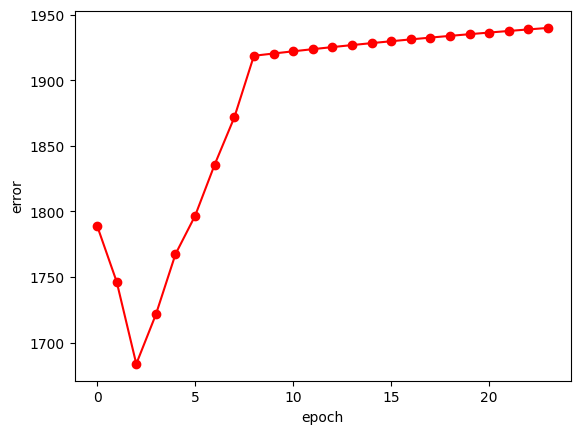

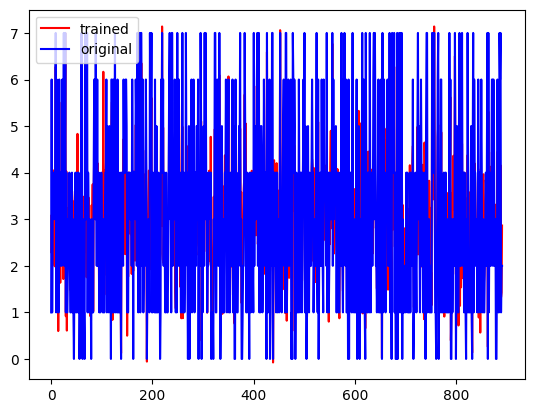

In [33]:
anfis_model, _ = doAnfis(X_train, X_test, Y_train, Y_test, 25, mf)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

current error: 1789.1771209884487


Processing:  33%|███▎      | 1/3 [13:55<27:51, 835.76s/it]

current error: 1746.3797175687519


Processing:  67%|██████▋   | 2/3 [28:09<14:04, 844.63s/it]


Accuracy: 19.28%


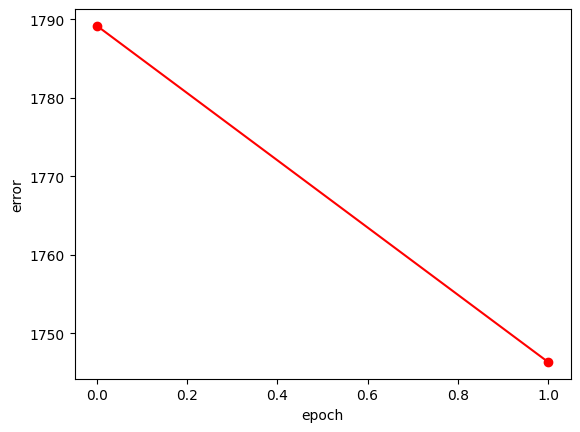

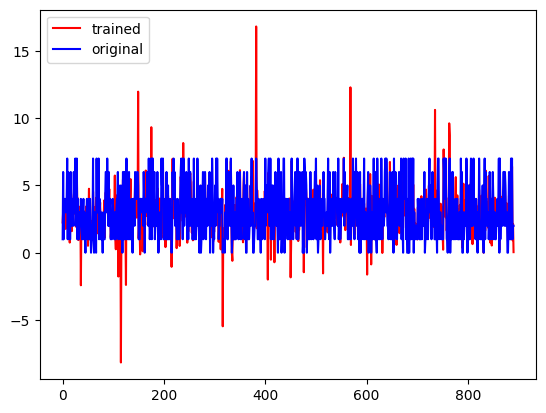

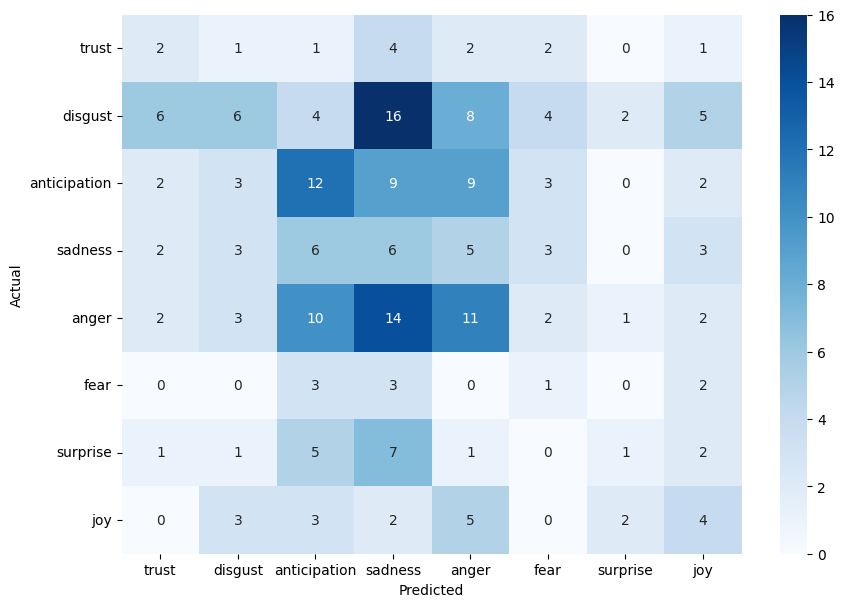

In [34]:
# mf = [
#     # exclamation_score
#     [['gaussmf', {'mean': 0.0, 'sigma': 0.02}],  # Very low exclamation
#      ['gaussmf', {'mean': 0.1, 'sigma': 0.1}]],  # Moderate to high exclamation  #sigma 0.5

#     # question_score
#     [['gaussmf', {'mean': 0.0, 'sigma': 0.02}],  # Very low question
#      ['gaussmf', {'mean': 0.1, 'sigma': 0.1}]],  # Moderate to high question  #sigma 0.5

#     # neg_score
#     [['gaussmf', {'mean': 0.03, 'sigma': 0.02}],  # Very low negativity
#      ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]],  # Moderate negativity

#     # afinn_score
#     [['gaussmf', {'mean': 0.5, 'sigma': 0.1}],   # Low to moderate afinn
#      ['gaussmf', {'mean': 0.6, 'sigma': 0.1}]],  # High afinn score  #mean 0.7 

#     # obj_score
#     [['gaussmf', {'mean': 0.7, 'sigma': 0.05}],  # Moderate objectivity
#      ['gaussmf', {'mean': 0.85, 'sigma': 0.05}]], # High objectivity

#     # vader_neg
#     [['gaussmf', {'mean': 0.03, 'sigma': 0.02}], # Very low negativity
#      ['gaussmf', {'mean': 0.1, 'sigma': 0.05}]], # Low to moderate negativity

#     # vader_neu
#     [['gaussmf', {'mean': 0.7, 'sigma': 0.05}],  # Moderate neutrality
#      ['gaussmf', {'mean': 0.9, 'sigma': 0.05}]], # High neutrality

#     # vader_pos
#     [['gaussmf', {'mean': 0.05, 'sigma': 0.03}],  # Low positivity
#      ['gaussmf', {'mean': 0.15, 'sigma': 0.05}]]  # Moderate positivity
# ]

anfis_model_2, predictions_2 = doAnfis(X_train, X_test, Y_train, Y_test, 3, mf)

cm = confusion_matrix(Y_test, predictions_2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mapping_dict.keys(), yticklabels=mapping_dict.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
plt.show()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(Y_test, predictions_2, average='weighted')
recall = recall_score(Y_test, predictions_2, average='weighted')
f1 = f1_score(Y_test, predictions_2, average='weighted')

print(f"Precision: {precision * 100:.3f}%")
print(f"Recall: {recall * 100:.3f}%")
print(f"F1-score: {f1 * 100:.3f}%")

labels = processed_data['Emotion'].unique()
print(classification_report(Y_test, predictions_2, target_names=labels))


Precision: 22.416%
Recall: 19.283%
F1-score: 19.391%
              precision    recall  f1-score   support

       trust       0.13      0.15      0.14        13
     disgust       0.30      0.12      0.17        51
anticipation       0.27      0.30      0.29        40
     sadness       0.10      0.21      0.13        28
       anger       0.27      0.24      0.26        45
        fear       0.07      0.11      0.08         9
    surprise       0.17      0.06      0.08        18
         joy       0.19      0.21      0.20        19

    accuracy                           0.19       223
   macro avg       0.19      0.18      0.17       223
weighted avg       0.22      0.19      0.19       223



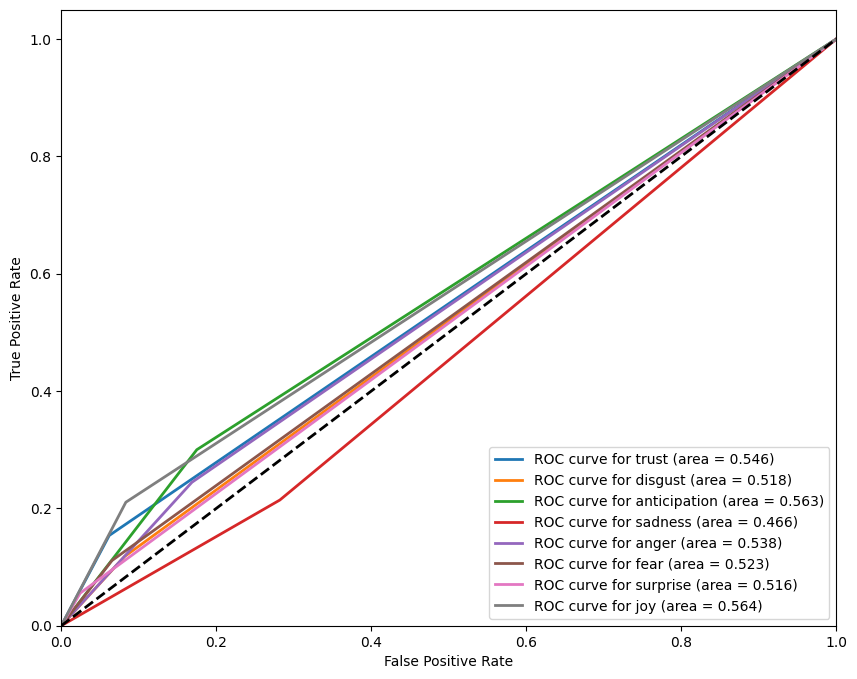

Macro-average AUC: 0.529


In [36]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

classes = processed_data['Emotion'].unique()
n_classes = len(classes)

Y_test_bin = label_binarize(Y_test, classes=range(n_classes))
predictions_prob = label_binarize(predictions_2, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:.3f})')

# Plot the diagonal line (random guess line)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve (Multi-class)')
plt.legend(loc="lower right")
plt.show()

# Calculate macro-average AUC
macro_roc_auc = roc_auc_score(Y_test_bin, predictions_prob, average='macro')
print(f'Macro-average AUC: {macro_roc_auc:.3f}')

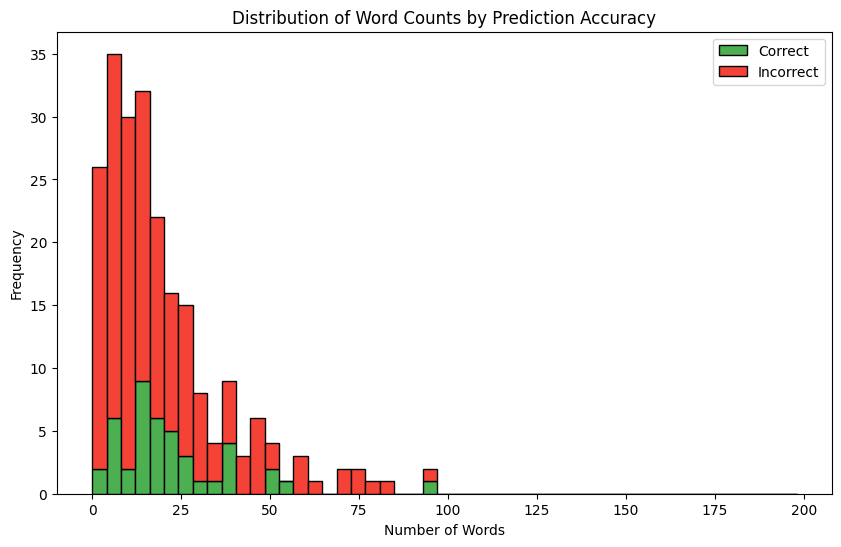

In [37]:
# Assuming Y_test is a NumPy array, get the original indices from the test set
test_indices = processed_data.index[X_train.shape[0]:]  # Assuming the data was split sequentially

# Find indices of correct and incorrect predictions
correct_indices = np.where(predictions_2 == Y_test)[0]
incorrect_indices = np.where(predictions_2 != Y_test)[0]

# Use the test indices to map back to the processed_data dataframe
correct_test_indices = test_indices[correct_indices]
incorrect_test_indices = test_indices[incorrect_indices]

# Get the lengths of 'Text' for correct and incorrect predictions
correct_text_lengths = processed_data.loc[correct_test_indices, 'tokens'].apply(len)
incorrect_text_lengths = processed_data.loc[incorrect_test_indices, 'tokens'].apply(len)

# Define the bin edges for the text lengths
bins = np.linspace(0, max(processed_data['tokens'].apply(len)), 50)

# Prepare the data for the histogram
correct_hist, _ = np.histogram(correct_text_lengths, bins=bins)
incorrect_hist, _ = np.histogram(incorrect_text_lengths, bins=bins)

# Create the plot with stacked bars
plt.figure(figsize=(10, 6))

# Plot histograms stacked on top of each other, similar to the uploaded example
plt.hist([correct_text_lengths, incorrect_text_lengths], bins=bins, stacked=True,
         label=['Correct', 'Incorrect'], color=['#4CAF50', '#F44336'], edgecolor='black')

# Add labels and title
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts by Prediction Accuracy')
plt.legend()

# Show the plot
plt.show()